In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
import matplotlib
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# load imagenet class names for visualization usage
class_name_txt = 'imagenet1000_clsid_to_human.txt'
lines = open(class_name_txt).readlines()
class_map, inverse_class_map = {}, {}
for line in lines:
    line_split = line.strip().strip(',').strip("'").split(": '")
    class_id = int(line_split[0])
    class_name = line_split[1]
    class_map[class_id] = class_name
    inverse_class_map[class_name] = class_id

In [21]:
# Load the pretrained model
# pretrained_model = models.resnet18(pretrained=True)
pretrained_model = models.vgg11(pretrained=True)
# Set model to evaluation mode
pretrained_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [22]:
scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

340 zebra


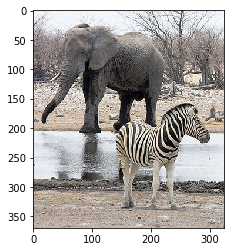

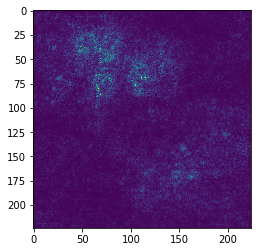

In [23]:
image_name = 'images/elephant_zebra_1.jpg'
img = Image.open(image_name)
t_img = normalize(to_tensor(scaler(img))).unsqueeze(0)
# t_img = t_img.to(device)
t_img.requires_grad = True
output = pretrained_model(t_img)
_, label = torch.max(output, 1)
plt.subplots(1)
plt.imshow(img)
label = label.numpy()[0]
print(label, class_map[label])
output[0, label].backward()
image_grad = t_img.grad.squeeze(0).permute(1, 2, 0)
gradient_map = torch.abs(image_grad).numpy()
gradient_map = np.max(gradient_map, 2)
gradient_map = gradient_map / np.max(gradient_map)
plt.subplots(1)
plt.imshow(gradient_map)
plt.show()

In [24]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    def __init__(self, features, num_classes=1000):
        super(VGG, self).__init__()
        classifiers = [
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        ]
        self.layers = nn.ModuleList(features + classifiers)
        self.reshape_feature_layer_num = len(features)

    def forward(self, x):
        layer_sizes = []
        for i, layer in list(enumerate(self.layers)):
            if i == self.reshape_feature_layer_num:
                x = x.view(x.size(0), -1)
            x = layer(x)
            layer_sizes.append(x.size())
        return x, layer_sizes

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return layers


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A")
    """
    model = VGG(make_layers(cfg['A']), **kwargs)
    return model


def vgg11_bn(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    """
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)
    return model


def vgg13(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B")
    """
    model = VGG(make_layers(cfg['B']), **kwargs)
    return model


def vgg13_bn(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    """
    model = VGG(make_layers(cfg['B'], batch_norm=True), **kwargs)
    return model


def vgg16(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")
    """
    model = VGG(make_layers(cfg['D']), **kwargs)
    return model


def vgg16_bn(**kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    """
    model = VGG(make_layers(cfg['D'], batch_norm=True), **kwargs)
    return model


def vgg19(**kwargs):
    """VGG 19-layer model (configuration "E")
    """
    model = VGG(make_layers(cfg['E']), **kwargs)
    return model


def vgg19_bn(**kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    """
    model = VGG(make_layers(cfg['E'], batch_norm=True), **kwargs)
    return model

In [25]:
new_model = vgg11()
new_model.eval()

VGG(
  (layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kernel

In [26]:
pretrained_layers = list(pretrained_model.state_dict().items())
count=0
for key, value in new_model.state_dict().items():
    layer_name, weights = pretrained_layers[count]
    new_model.state_dict()[key].data.copy_(weights)
    count+=1

340 zebra


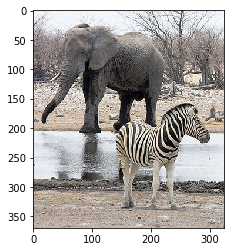

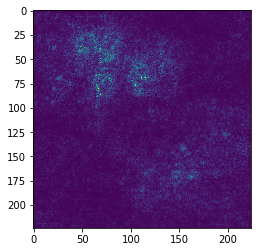

[torch.Size([1, 64, 224, 224]), torch.Size([1, 64, 224, 224]), torch.Size([1, 64, 112, 112]), torch.Size([1, 128, 112, 112]), torch.Size([1, 128, 112, 112]), torch.Size([1, 128, 56, 56]), torch.Size([1, 256, 56, 56]), torch.Size([1, 256, 56, 56]), torch.Size([1, 256, 56, 56]), torch.Size([1, 256, 56, 56]), torch.Size([1, 256, 28, 28]), torch.Size([1, 512, 28, 28]), torch.Size([1, 512, 28, 28]), torch.Size([1, 512, 28, 28]), torch.Size([1, 512, 28, 28]), torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 7, 7]), torch.Size([1, 4096]), torch.Size([1, 4096]), torch.Size([1, 4096]), torch.Size([1, 4096]), torch.Size([1, 4096]), torch.Size([1, 4096]), torch.Size([1, 1000])]


In [69]:
image_name = 'images/elephant_zebra_1.jpg'
img = Image.open(image_name)
t_img = normalize(to_tensor(scaler(img))).unsqueeze(0)
# t_img = t_img.to(device)
t_img.requires_grad = True
output, layer_sizes = new_model(t_img)
_, label = torch.max(output, 1)
plt.subplots(1)
plt.imshow(img)
label = label.numpy()[0]
print(label, class_map[label])
output[0, label].backward()
image_grad = t_img.grad.squeeze(0).permute(1, 2, 0)
gradient_map = torch.abs(image_grad).numpy()
gradient_map = np.max(gradient_map, 2)
gradient_map = gradient_map / np.max(gradient_map)
plt.subplots(1)
plt.imshow(gradient_map)
plt.show()
print(layer_sizes)

In [70]:
__all__ = [
    'VGG_FB', 'vgg11_fb', 'vgg11_fb_bn', 'vgg13_fb', 'vgg13_fb_bn', 'vgg16_fb', 'vgg16_fb_bn',
    'vgg19_fb_bn', 'vgg19_fb',
]


class VGG_FB(nn.Module):
    def __init__(self, features, layer_sizes, num_classes=1000):
        super(VGG_FB, self).__init__()
        classifiers = [
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=False),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=False),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        ]
        self.layers = nn.ModuleList(features + classifiers)
        self.reshape_feature_layer_num = len(features)
        # Add hidden gates for selective layers such as ReLU and Max-pooling
        self.z = {}
        for i, layer in list(enumerate(self.layers)):
            # if isinstance(layer, nn.ReLU):
            #     self.z[i] = torch.ones(layer_sizes[i])
            # elif isinstance(layer, nn.MaxPool2d):
            #     self.z[i] = torch.ones(layer_sizes[i])
            self.z[i] = torch.ones(layer_sizes[i])
    
    def reset(self):
        for i in self.z.keys():
            self.z[i] = torch.ones_like(self.z[i])
    
    def forward(self, x):
        self.input = []
        self.output = []
        for i, layer in list(enumerate(self.layers)):
            # detach from previous history
            x = Variable(x.data, requires_grad=True)
            self.input.append(x)
            if i == self.reshape_feature_layer_num:
                x = x.view(x.size(0), -1)
            # compute output
            x = layer(x)
            if i in self.z:
                # multiply by the hidden gate
                x = x * self.z[i]
            # add to list of outputs
            self.output.append(x)
        return x
    
    def backward(self, g):
        for i, output in reversed(list(enumerate(self.output))):
            if i == (len(self.output) - 1):
                # for last node, use g
                output.backward(g)
            else:
                output.backward(self.input[i+1].grad.data)
            if i in self.z:
                alpha = self.input[i].grad
                self.z[i] = (alpha > 0).float()
                self.input[i].grad = self.z[i] * alpha
            print(i, self.input[i].grad.data.sum())
        return self.input[0].grad

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=False)]
            else:
                layers += [conv2d, nn.ReLU(inplace=False)]
            in_channels = v
    return layers


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11_fb(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A")
    """
    model = VGG_FB(make_layers(cfg['A']), **kwargs)
    return model


def vgg11_fb_bn(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    """
    model = VGG_FB(make_layers(cfg['A'], batch_norm=True), **kwargs)
    return model


def vgg13_fb(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B")
    """
    model = VGG_FB(make_layers(cfg['B']), **kwargs)
    return model


def vgg13_fb_bn(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    """
    model = VGG_FB(make_layers(cfg['B'], batch_norm=True), **kwargs)
    return model


def vgg16_fb(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")
    """
    model = VGG_FB(make_layers(cfg['D']), **kwargs)
    return model


def vgg16_fb_bn(**kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    """
    model = VGG_FB(make_layers(cfg['D'], batch_norm=True), **kwargs)
    return model


def vgg19_fb(**kwargs):
    """VGG 19-layer model (configuration "E")
    """
    model = VGG_FB(make_layers(cfg['E']), **kwargs)
    return model


def vgg19_fb_bn(**kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    """
    model = VGG_FB(make_layers(cfg['E'], batch_norm=True), **kwargs)
    return model

In [71]:
feedback_model = vgg11_fb(layer_sizes=layer_sizes)
feedback_model.eval()

VGG_FB(
  (layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [72]:
pretrained_layers = list(pretrained_model.state_dict().items())
count=0
for key, value in feedback_model.state_dict().items():
    layer_name, weights = pretrained_layers[count]
    feedback_model.state_dict()[key].data.copy_(weights)
    count+=1

340 zebra
27 tensor(25.3062)
26 tensor(25.3062)
25 tensor(10.2183)
24 tensor(20.0382)
23 tensor(20.0382)
22 tensor(8.7405)
21 tensor(37.1727)
20 tensor(37.1727)
19 tensor(10.7830)
18 tensor(53.0057)
17 tensor(20.3765)
16 tensor(68.0056)
15 tensor(68.0056)
14 tensor(29.7851)
13 tensor(122.3407)
12 tensor(58.3115)
11 tensor(131.4356)
10 tensor(131.4356)
9 tensor(82.6248)
8 tensor(294.4703)
7 tensor(167.4607)
6 tensor(391.4113)
5 tensor(391.4113)
4 tensor(303.2060)
3 tensor(844.6482)
2 tensor(844.6482)
1 tensor(788.6061)
0 tensor(1563.6064)


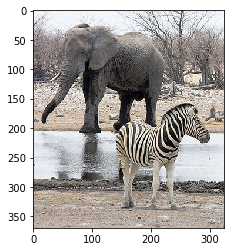

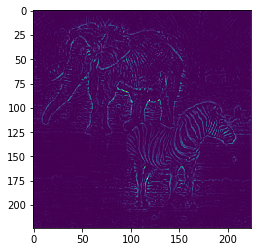

In [73]:
image_name = 'images/elephant_zebra_1.jpg'
img = Image.open(image_name)
t_img = normalize(to_tensor(scaler(img))).unsqueeze(0)
# t_img = t_img.to(device)
feedback_model.reset()
output = feedback_model(t_img)
_, label = torch.max(output, 1)
plt.subplots(1)
plt.imshow(img)
label = label.numpy()[0]
print(label, class_map[label])
gradients = torch.zeros(*output.size())
gradients[0, label] = 1.0
image_grad = feedback_model.backward(gradients)
image_grad = image_grad.squeeze(0).permute(1, 2, 0)
gradient_map = torch.abs(image_grad).numpy()
gradient_map = np.max(gradient_map, 2)
gradient_map = gradient_map / np.max(gradient_map)
plt.subplots(1)
plt.imshow(gradient_map)
plt.show()